In [ ]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os, fnmatch, glob
from glob import glob 
from sklearn.model_selection import train_test_split
%matplotlib inline
from PIL import Image
import torchvision.transforms as tfs
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import scipy
import scipy.io
import cv2
from numpy import linalg as LA
import matplotlib.image as mpimg
from matplotlib import gridspec
#import scipy.io as io

# Density Map

In [ ]:
#https://github.com/CommissarMa/Crowd_counting_from_scratch/blob/master/generate_density_map/same_gaussian_kernel.py
import numpy as np


def generate_density_map_with_fixed_kernel(img,points,kernel_size=15,sigma=3):
    '''
    img: input image.
    points: annotated pedestrian's position like [row,col]
    kernel_size: the fixed size of gaussian kernel, must be odd number.
    sigma: the sigma of gaussian kernel.
    return:
    d_map: density-map we want
    '''
    def guassian_kernel(size,sigma):
        rows=size[0] # mind that size must be odd number.
        cols=size[1]
        mean_x=int((rows-1)/2)
        mean_y=int((cols-1)/2)
        f=np.zeros(size)
        for x in range(0,rows):
            for y in range(0,cols):
                mean_x2=(x-mean_x)*(x-mean_x)
                mean_y2=(y-mean_y)*(y-mean_y)
                f[x,y]=(1.0/(2.0*np.pi*sigma*sigma))*np.exp((mean_x2+mean_y2)/(-2.0*sigma*sigma))
        return f

    [rows,cols]=[img.shape[0],img.shape[1]]
    d_map=np.zeros([rows,cols])
    f=guassian_kernel([kernel_size,kernel_size],sigma) # generate gaussian kernel with fixed size.
    normed_f=(1.0/f.sum())*f # normalization for each head.
    if len(points)==0:
        return d_map
    else:
        for p in points:
            r,c=int(p[1]),int(p[0])
            if r>=rows or c>=cols:
                continue
            for x in range(0,f.shape[0]):
                for y in range(0,f.shape[1]):
                    if x+((r+1)-int((f.shape[0]-1)/2))<0 or x+((r+1)-int((f.shape[0]-1)/2))>rows-1 \
                    or y+((c+1)-int((f.shape[1]-1)/2))<0 or y+((c+1)-int((f.shape[1]-1)/2))>cols-1:
                        continue
                    else:
                        d_map[x+((r+1)-int((f.shape[0]-1)/2)),y+((c+1)-int((f.shape[1]-1)/2))]+=normed_f[x,y]
    return d_map

**Train Data**

In [ ]:
dataBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/train_data/images/*.jpg'
labelBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/train_data/ground-truth/*.mat'
dataDir = sorted(glob(dataBaseAddr))
labelDir = sorted(glob(labelBaseAddr))

In [ ]:
for imgDir, labDir in zip(dataDir, labelDir): 
  img=plt.imread(imgDir)
  mat = scipy.io.loadmat(labDir)
  pts = mat["image_info"][0,0][0,0][0]
  density_map = generate_density_map_with_fixed_kernel(img, pts)
  np.save(labDir.replace('ground-truth','GTDPNew'), density_map)

**Test Data**

In [ ]:
dataBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/test_data/images/*.jpg'
labelBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/test_data/ground-truth/*.mat'
dataDir = sorted(glob(dataBaseAddr))
labelDir = sorted(glob(labelBaseAddr))

In [ ]:
for imgDir, labDir in zip(dataDir, labelDir): 
  img=plt.imread(imgDir)
  mat = scipy.io.loadmat(labDir)
  pts = mat["image_info"][0,0][0,0][0]
  density_map = generate_density_map_with_fixed_kernel(img, pts)
  np.save(labDir.replace('ground-truth','GTDTNew'), density_map)

# **Data Augmentation**

In [ ]:
dataBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/train_data/images/*.jpg'
labelBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/train_data/ground-truth/*.mat'
dataDir = sorted(glob(dataBaseAddr))
labelDir = sorted(glob(labelBaseAddr))

In [ ]:
def transformation(image, mat): 
  points = mat["image_info"][0,0][0,0][0]
  pointsAu = points[np.newaxis, :,:]
  image  =  image[np.newaxis,:,:,:]
  st = lambda aug: iaa.Sometimes(0.5, aug)
  seq = iaa.Sequential([
          iaa.Fliplr(0.5), # horizontally flip 50% of all images
          iaa.Flipud(0.5),
          st(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.2), per_channel=0.5)),
          st(iaa.Dropout((0.0, 0.1), per_channel=0.5)),
          st(iaa.Affine(
              scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
              translate_px={"x": (-16, 16), "y": (-16, 16)}, # translate by -16 to +16 pixels (per axis)
              rotate=(-45, 45), # rotate by -45 to +45 degrees
              shear=(-16, 16), # shear by -16 to +16 degrees
              order=ia.ALL, # use any of scikit-image's interpolation methods
              cval=(0, 255), # if mode is constant, use a cval between 0 and 255
              mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
          )), 
          ],
      random_order=True # do all of the above in random order
 )
  # augment keypoints and images
  images_aug, points_aug = seq(images=image, keypoints=pointsAu)
  return images_aug, points_aug



In [ ]:
i = 400
for imgDir, labDir in zip(dataDir, labelDir): 
  img = plt.imread(imgDir)
  mat = scipy.io.loadmat(labDir)
  imgAug, ptsAug = transformation(img, mat)
  density_map = generate_density_map_with_fixed_kernel(imgAug[0], ptsAug[0])
  np.save('/content/drive/MyDrive/Deep Hw2/Problem2/part_B/train_data/GTDPNew/{}.npy'.format(i), density_map)
  imgAug = Image.fromarray(imgAug[0])
  imgAug.save('/content/drive/MyDrive/Deep Hw2/Problem2/part_B/train_data/images/{}.jpg'.format(i))
  i = i+1
  if i%80 ==79:
    break

**Show Augmentation Result**

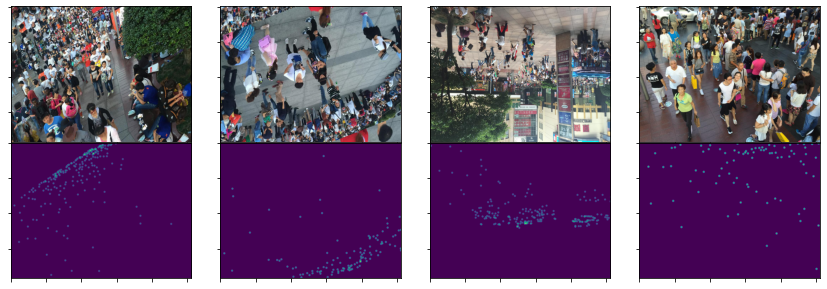

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


plt.figure(figsize = (15,5))
gs1 = gridspec.GridSpec(2, 4)
gs1.update(wspace=0.005, hspace=0.005) 
for i in range(4):
  gt_dpAug = np.load('/content/drive/MyDrive/TestPy/{}.npy'.format(i))
  imgAug = plt.imread('/content/drive/MyDrive/TestPy/{}.jpg'.format(i))
  ax1 = plt.subplot(gs1[i])
  plt.axis('on')
  ax1.set_xticklabels([])
  ax1.set_yticklabels([])
  ax1.set_aspect('equal')
  ax1.imshow(imgAug)
  ax1 = plt.subplot(gs1[i+4])
  plt.axis('on')
  ax1.set_xticklabels([])
  ax1.set_yticklabels([])
  ax1.set_aspect('equal')
  ax1.imshow(gt_dpAug)


# **Gray Images**


In [ ]:
#https://www.delftstack.com/howto/python/convert-image-to-grayscale-python/
def rgbGray(imgDir):
  img = mpimg.imread(imgDir)
  R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
  imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
  return imgGray
#plt.imshow(imgGray, cmap='gray')
#plt.show()

# **Patch Images**

In [ ]:
class shangTechDataset(Dataset):
  def __init__(self, transformer, dataDirs, labelDirs):
    self.trans = transformer
    self.data_list = dataDirs
    self.label_list = labelDirs
  def __getitem__(self, idx):
    label = np.load(self.label_list[idx])
    img = rgbGray(self.data_list[idx])
    img = torch.from_numpy(img)
    label = torch.from_numpy(label)
    imgPatches = img.unfold(0, 256, 256).unfold(1, 256, 256)
    labelPatches = label.unfold(0, 256, 256).unfold(1, 256, 256)
    return  imgPatches, labelPatches
  def __len__(self):
    return len(self.data_list)

**Train Data**


In [ ]:
dataBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/train_data/images/*.jpg'
labelBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/train_data/GTDPNew/*.npy'
dataDir = sorted(glob(dataBaseAddr))
labelDir = sorted(glob(labelBaseAddr))

In [ ]:
np.shape(labelDir), np.shape(dataDir)

((479,), (479,))

In [ ]:
shangTransform = []
BATCHSIZE = 1
trainData = shangTechDataset(transformer = shangTransform, dataDirs = dataDir, labelDirs = labelDir)
trainDataSHT = DataLoader(trainData, batch_size=BATCHSIZE, shuffle=True)

In [ ]:
i = 0
for img,gt_dmap in trainDataSHT:
  imgi = img.view(-1, 256, 256)
  gt_dmapi = gt_dmap.view(-1, 256, 256)
  for imgData, imgLabel in zip(imgi, gt_dmapi):
    np.save('/content/drive/MyDrive/Deep Hw2/Problem2/part_B/train_data/GT_PatchesNew/{0}.npy'.format(i), imgLabel.numpy())
    np.save('/content/drive/MyDrive/Deep Hw2/Problem2/part_B/train_data/IMG_PatchesNew/{0}.npy'.format(i), imgData.numpy())
    i = i+1

In [ ]:
labelBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/train_data/GT_PatchesNew/*.npy'
dataBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/train_data/IMG_PatchesNew/*.npy'
dataDir = sorted(glob(dataBaseAddr))
labelDir = sorted(glob(labelBaseAddr))

In [ ]:
np.shape(dataDir)

((5748,), 5748)

In [ ]:
myLabel = []
myImg = []
for i in range(12):
  myLabel.append(np.load('/content/drive/MyDrive/Deep Hw2/Problem2/part_B/train_data/GT_PatchesNew/{0}.npy'.format(i)))
  myImg.append(np.load('/content/drive/MyDrive/Deep Hw2/Problem2/part_B/train_data/IMG_PatchesNew/{0}.npy'.format(i)))


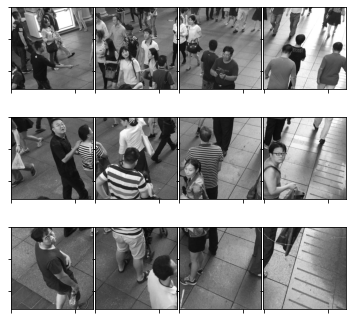

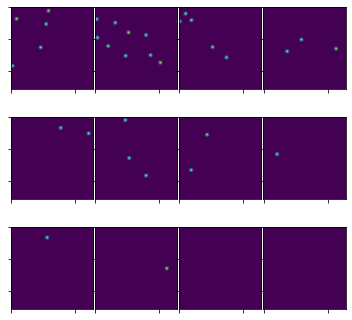

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.figure(figsize = (6,8))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(12):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ax1.imshow(myImg[i], cmap='gray')
plt.show()

plt.figure(figsize = (6,8))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) 
for i in range(12):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ax1.imshow(myLabel[i])
plt.show()

**Test Data**


In [ ]:
dataBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/test_data/images/*.jpg'
labelBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/test_data/GTDTNew/*.npy'
dataDir = sorted(glob(dataBaseAddr))
labelDir = sorted(glob(labelBaseAddr))

In [ ]:
print(np.shape(dataDir), np.shape(labelDir))

(316,) (316,)


In [ ]:
shangTransform = 5
BATCHSIZE = 1
trainData = shangTechDataset(transformer = shangTransform, dataDirs = dataDir, labelDirs = labelDir)
trainDataSHT = DataLoader(trainData, batch_size=BATCHSIZE, shuffle=True)

In [ ]:
i = 0
for img,gt_dmap in trainDataSHT:
  imgi = img.view(-1, 256, 256)
  gt_dmapi = gt_dmap.view(-1, 256, 256)
  for imgData, imgLabel in zip(imgi, gt_dmapi):
    np.save('/content/drive/MyDrive/Deep Hw2/Problem2/part_B/test_data/GT_PatchesNew/{0}.npy'.format(i), imgLabel.numpy())
    np.save('/content/drive/MyDrive/Deep Hw2/Problem2/part_B/test_data/IMG_PatchesNew/{0}.npy'.format(i), imgData.numpy())
    i = i+1

In [ ]:
labelBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/test_data/GT_PatchesNew/*.npy'
dataBaseAddr = '/content/drive/MyDrive/Deep Hw2/Problem2/part_B/test_data/IMG_PatchesNew/*.npy'
dataDirTest = sorted(glob(dataBaseAddr))
labelDirTest = sorted(glob(labelBaseAddr))

In [ ]:
np.shape(dataDirTest), np.shape(labelDirTest), 316*12

((3792,), (3792,), 3792)

In [ ]:
myLabel = []
myImg = []
for i in range(12):
  myLabel.append(np.load('/content/drive/MyDrive/Deep Hw2/Problem2/part_B/test_data/GT_PatchesNew/{0}.npy'.format(i)))
  myImg.append(np.load('/content/drive/MyDrive/Deep Hw2/Problem2/part_B/test_data/IMG_PatchesNew/{0}.npy'.format(i)))


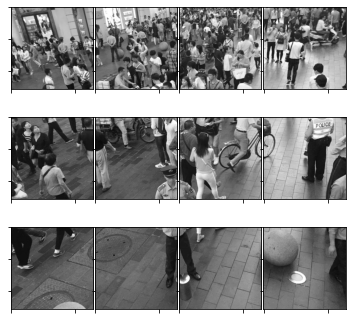

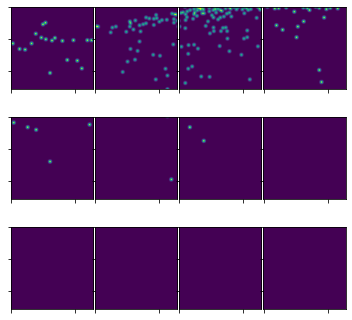

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.figure(figsize = (6,8))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(12):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ax1.imshow(myImg[i], cmap='gray')
plt.show()

plt.figure(figsize = (6,8))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) 
for i in range(12):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ax1.imshow(myLabel[i])
plt.show()